<font size = 5>Data Set Information:</font>

The analysis is performed for different sets of input values using the methodology similar to that described in [SchÃ¤fer, Benjamin, et al. 'Taming instabilities in power grid networks by decentralized control.' The European Physical Journal Special Topics 225.3 (2016): 569-582.]. Several input values are kept the same: averaging time: 2 s; coupling strength: 8 s^-2; damping: 0.1 s^-1


<font size = 5>Attribute Information:</font>

11 predictive attributes, 1 non-predictive(p1), 2 goal fields: 
1. tau[x]: reaction time of participant (real from the range [0.5,10]s). Tau1 - the value for electricity producer. 
2. p[x]: nominal power consumed(negative)/produced(positive)(real). For consumers from the range [-0.5,-2]s^-2; p1 = abs(p2 + p3 + p4) 
3. g[x]: coefficient (gamma) proportional to price elasticity (real from the range [0.05,1]s^-1). g1 - the value for electricity producer. 
4. stab: the maximal real part of the characteristic equation root (if positive - the system is linearly unstable)(real) 
5. stabf: the stability label of the system (categorical: stable/unstable) 



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model, metrics, model_selection
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import PolynomialFeatures

In [2]:
df = pd.read_csv('Data_for_UCI_named.csv')
df = df.drop('p1',axis = 1)
df.head()


,tau1,tau2,tau3,tau4,p2,p3,p4,g1,g2,g3,g4,stab,stabf
0,2.959060,3.079885,8.381025,9.780754,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,0.055347,unstable
1,9.304097,4.902524,3.047541,1.369357,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,-0.005957,stable
2,8.971707,8.848428,3.046479,1.214518,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,0.003471,unstable
3,0.716415,7.669600,4.486641,2.340563,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718,0.028871,unstable
4,3.134112,7.608772,4.943759,9.857573,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923,0.049860,unstable


In [3]:
print(df.shape[0] - df.count())  #看一下有沒有缺值

tau1     0
tau2     0
tau3     0
tau4     0
p2       0
p3       0
p4       0
g1       0
g2       0
g3       0
g4       0
stab     0
stabf    0
dtype: int64


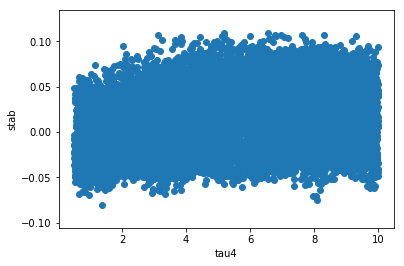

In [4]:
def scatter(_data, x_name):
    plt.scatter(_data[x_name], _data['stab'])
    plt.xlabel(x_name)
    plt.ylabel('stab')
    plt.show()

scatter(df, 'tau4')

前90%當作training set，後10%當作testing set，因為題目想要預測stab跟stabf，而stabf是取決於stab的正負，所以我想用回歸來預測stab。

In [5]:
x_train = df.loc[:8999,(df.columns!='stab')&(df.columns!='stabf')]
y_train = df.loc[:8999,'stab']
x_test = df.loc[9000:,(df.columns!='stab')&(df.columns!='stabf')]
y_test = df.loc[9000:,'stab']
y_test?

In [6]:
def scorer(model, X, y):
    preds = model.predict(X)
    return metrics.mean_squared_error(y, preds)

In [7]:
alphas = np.linspace(start=0, stop=0.5, num=11)
alphas

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ])

In [8]:
"""
Task: Perform 10-fold cross validation on all values of alpha and save the mses.
"""
mses = []
for alpha in alphas:
    ridge = linear_model.Ridge(alpha=alpha, normalize=True)
    mse = model_selection.cross_val_score(ridge, x_train, y_train, cv=10, scoring=scorer)
    mses.append(mse.mean())

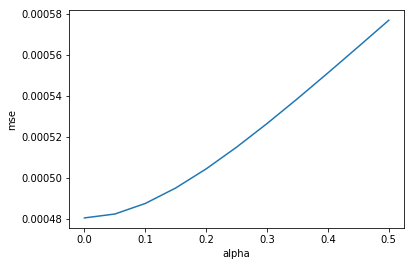

In [9]:
plt.plot(alphas, mses)
plt.xlabel('alpha')
plt.ylabel('mse')
plt.show()

In [10]:
best_alpha = alphas[np.argmin(mses)]
best_alpha

0.0

In [11]:
ridge = linear_model.Ridge(alpha=best_alpha, normalize=True)
ridge.fit(x_train, y_train)
test_preds = ridge.predict(x_test)
test_mse = metrics.mean_squared_error(y_test, test_preds)
print('Test MSE: %s' % test_mse)

Test MSE: 0.0004982381109651277


看一下用一次回歸的方式預測stabf的準確率

In [12]:
preds = pd.DataFrame(test_preds)
for i in range(preds.shape[0]):
    if preds.loc[i,0]>0:
        preds.loc[i,'stabf'] = 'unstable'
    else:
        preds.loc[i,'stabf'] = 'stable'
preds.head(10)
accuracy_score(df.loc[9000:,'stabf'],preds['stabf'])

0.802

In [13]:
for i in range(0, len(df.columns) - 2):
    print('Coefficient for %s:%s\t%s' %
          (df.columns[i], 
           '\t' if len(df.columns[i]) < 7 else '',
           ridge.coef_[i]))

Coefficient for tau1:		0.003635127653695754
Coefficient for tau2:		0.0037448093081122497
Coefficient for tau3:		0.003715424552699879
Coefficient for tau4:		0.0037562516538353703
Coefficient for p2:		-0.00015633277623285625
Coefficient for p3:		0.0009721260278446723
Coefficient for p4:		-0.0006728459175244343
Coefficient for g1:		0.03812083286809722
Coefficient for g2:		0.038532419251920795
Coefficient for g3:		0.04059126911536128
Coefficient for g4:		0.038553156529347175


回歸後發現p3跟p4的係數比較小，試圖用比較少的features來再做一次回歸

In [14]:
x_train = df.loc[:8999,(df.columns!='stab')&(df.columns!='stabf')&(df.columns!='p3')&(df.columns!='p4')]
y_train = df.loc[:8999,'stab']
x_test = df.loc[9000:,(df.columns!='stab')&(df.columns!='stabf')&(df.columns!='p3')&(df.columns!='p4')]
y_test = df.loc[9000:,'stab']

In [15]:
"""
Task: Perform 10-fold cross validation on all values of alpha and save the mses.
"""
mses = []
for alpha in alphas:
    ridge = linear_model.Ridge(alpha=alpha, normalize=True)
    mse = model_selection.cross_val_score(ridge, x_train, y_train, cv=10, scoring=scorer)
    mses.append(mse.mean())

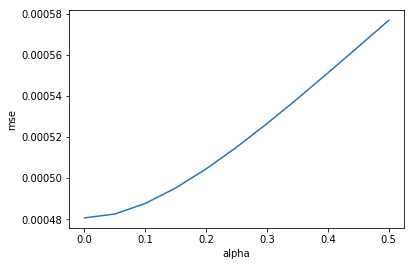

In [16]:
plt.plot(alphas, mses)
plt.xlabel('alpha')
plt.ylabel('mse')
plt.show()

In [17]:
best_alpha = alphas[np.argmin(mses)]
best_alpha

0.0

In [18]:
ridge = linear_model.Ridge(alpha=best_alpha, normalize=True)
ridge.fit(x_train, y_train)
test_preds = ridge.predict(x_test)
test_mse = metrics.mean_squared_error(y_test, test_preds)
print('Test MSE: %s' % test_mse)

Test MSE: 0.000497639989876742


In [19]:
preds = pd.DataFrame(test_preds)
for i in range(preds.shape[0]):
    if preds.loc[i,0]>0:
        preds.loc[i,'stabf'] = 'unstable'
    else:
        preds.loc[i,'stabf'] = 'stable'
preds.head(10)
accuracy_score(df.loc[9000:,'stabf'],preds['stabf'])

0.797

失敗後，再試試看用二次回歸，因為資料集寫這是某個方程式的根的實部，不用更高次是怕overfitting

In [20]:
poly_reg = PolynomialFeatures(degree = 2)
X_poly = poly_reg.fit_transform(x_train)
lin_reg_2 = linear_model.LinearRegression()
lin_reg_2.fit(X_poly, y_train)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [21]:
poly_reg = PolynomialFeatures(degree = 2)
X_poly = poly_reg.fit_transform(x_test)
test_preds = lin_reg_2.predict(X_poly)
test_mse = metrics.mean_squared_error(y_test, test_preds)
print('Test MSE: %s' % test_mse)

Test MSE: 0.00015086251761225726


In [22]:
preds = pd.DataFrame(test_preds)
for i in range(preds.shape[0]):
    if preds.loc[i,0]>0:
        preds.loc[i,'stabf'] = 'unstable'
    else:
        preds.loc[i,'stabf'] = 'stable'
preds.head(10)
accuracy_score(df.loc[9000:,'stabf'],preds['stabf'])

0.924